# Import Package

In [1]:
from tkinter import *
from tkinter import messagebox
from tkinter import filedialog
import tkinter as tk
import os 
from PIL import Image, ImageTk
#import re

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import torchvision
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
import time
import albumentations
import argparse

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

# Paths of Directories

In [2]:
sharp_dir = '../Dataset/sharp/'
gblur_dir = '../Dataset/gaussian_blurred/'
out_dir = '../outputs/'
image_dir = out_dir + 'saved_images/'

# Define Device

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0' 
else:
    device = 'cpu'
print(device)

cpu


C:\Users\hp\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Save Image

In [4]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

# Auto Encoder

In [5]:
# CNN Auto Encoder 
class SimpleAE(nn.Module):
    def __init__(self):
        super(SimpleAE, self).__init__() # call the constructor of parent class 
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(64, 32, kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define Model

In [6]:
# Define Model
model = SimpleAE().to(device)
print(model)

SimpleAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
)


# Define Epoch

In [7]:
#parser = argparse.ArgumentParser()
#parser.add_argument('-e', '--epochs', type=int, default=60, help='number of epochs to train the model for')
#args = parser.parse_known_args()[0]
#epochs=args.epochs
epochs = 60
print(epochs)

60


# Construct Output Directory

In [8]:
#image_dir = '../outputs/saved_images'
#os.makedirs(image_dir, exist_ok=True)

# Define Transforms

In [9]:
# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define Loss Function

In [10]:
criterion = nn.MSELoss()

# Define Batch Size

In [11]:
batch_size = 1

# Define Optimizer

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min',
        patience=5,
        factor=0.1,
        verbose=True
    )

# Train

## Add Guassian Blur

In [13]:
'''# Add guassian blur
images = os.listdir(sharp_dir)
for i, img in tqdm(enumerate(images), total=len(images)):
    img = cv2.imread(f"{sharp_dir}{images[i]}")
    # add gaussian blurring
    blur = cv2.GaussianBlur(img, (51, 51), 0)
    dest = images[i].split(".")[0][:-2]
    dest = os.path.join(gblur_dir,dest+"_G.jpg")
    cv2.imwrite(f"{dest}", blur)
print('DONE')'''

'# Add guassian blur\nimages = os.listdir(sharp_dir)\nfor i, img in tqdm(enumerate(images), total=len(images)):\n    img = cv2.imread(f"{sharp_dir}{images[i]}")\n    # add gaussian blurring\n    blur = cv2.GaussianBlur(img, (51, 51), 0)\n    dest = images[i].split(".")[0][:-2]\n    dest = os.path.join(gblur_dir,dest+"_G.jpg")\n    cv2.imwrite(f"{dest}", blur)\nprint(\'DONE\')'

## Form Input and Output Dataset

In [14]:
# form input and output dataset
gauss_blur = os.listdir(gblur_dir) 
gauss_blur.sort() 
sharp = os.listdir(sharp_dir) 
sharp.sort()
X = []
for i in range(len(gauss_blur )):
    X.append(gblur_dir + gauss_blur[i])
Y = []
for i in range(len(sharp)):
    Y.append(sharp_dir + sharp[i])
print(np.shape(X))
print(np.shape(Y)) 

(350,)
(350,)


In [15]:
X

['../Dataset/gaussian_blurred/0_IPHONE-SE_G.jpg',
 '../Dataset/gaussian_blurred/100_NIKON-D3400-35MM_G.jpg',
 '../Dataset/gaussian_blurred/101_NIKON-D3400-35MM_G.jpg',
 '../Dataset/gaussian_blurred/102_NIKON-D3400-35MM_G.jpg',
 '../Dataset/gaussian_blurred/103_HUAWEI-P20_G.jpg',
 '../Dataset/gaussian_blurred/104_IPHONE-SE_G.jpg',
 '../Dataset/gaussian_blurred/105_IPHONE-SE_G.jpg',
 '../Dataset/gaussian_blurred/106_NIKON-D3400-35MM_G.jpg',
 '../Dataset/gaussian_blurred/107_XIAOMI-MI8-SE_G.jpg',
 '../Dataset/gaussian_blurred/108_XIAOMI-MI8-SE_G.jpg',
 '../Dataset/gaussian_blurred/109_HONOR-7X_G.jpg',
 '../Dataset/gaussian_blurred/10_ASUS-ZENFONE-LIVE-ZB501KL_G.jpg',
 '../Dataset/gaussian_blurred/110_IPHONE-7_G.jpg',
 '../Dataset/gaussian_blurred/111_IPHONE-7_G.jpg',
 '../Dataset/gaussian_blurred/112_NIKON-D3400-35MM_G.jpg',
 '../Dataset/gaussian_blurred/113_SAMSUNG-GALAXY-A5_G.jpg',
 '../Dataset/gaussian_blurred/114_ASUS-ZE500KL_G.jpg',
 '../Dataset/gaussian_blurred/115_NIKON-D3400-35MM_

In [16]:
Y

['../Dataset/sharp/0_IPHONE-SE_S.JPG',
 '../Dataset/sharp/100_NIKON-D3400-35MM_S.JPG',
 '../Dataset/sharp/101_NIKON-D3400-35MM_S.JPG',
 '../Dataset/sharp/102_NIKON-D3400-35MM_S.JPG',
 '../Dataset/sharp/103_HUAWEI-P20_S.jpg',
 '../Dataset/sharp/104_IPHONE-SE_S.jpg',
 '../Dataset/sharp/105_IPHONE-SE_S.jpg',
 '../Dataset/sharp/106_NIKON-D3400-35MM_S.JPG',
 '../Dataset/sharp/107_XIAOMI-MI8-SE_S.jpg',
 '../Dataset/sharp/108_XIAOMI-MI8-SE_S.jpg',
 '../Dataset/sharp/109_HONOR-7X_S.jpg',
 '../Dataset/sharp/10_ASUS-ZENFONE-LIVE-ZB501KL_S.jpg',
 '../Dataset/sharp/110_IPHONE-7_S.jpeg',
 '../Dataset/sharp/111_IPHONE-7_S.jpeg',
 '../Dataset/sharp/112_NIKON-D3400-35MM_S.JPG',
 '../Dataset/sharp/113_SAMSUNG-GALAXY-A5_S.jpg',
 '../Dataset/sharp/114_ASUS-ZE500KL_S.jpg',
 '../Dataset/sharp/115_NIKON-D3400-35MM_S.JPG',
 '../Dataset/sharp/116_BQ-5512L_S.jpg',
 '../Dataset/sharp/117_HONOR-7X_S.jpg',
 '../Dataset/sharp/118_HONOR-7X_S.jpg',
 '../Dataset/sharp/119_HONOR-7X_S.jpg',
 '../Dataset/sharp/11_XIAOMI

## Split Testing and Training Dataset

In [17]:
# Split input and output dataset into training and validation dataset
(x_train, x_val, y_train, y_val) = train_test_split(X, Y, test_size=0.25) 
print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))

262
88
262
88


## Training

In [31]:
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
    def __len__(self):
        #print(len(self.X))
        return (len(self.X))
    def __getitem__(self, i):
        #print(i)
        #print("Blurimage : ",self.X[i])
        #print("Sharpimage : ",self.y[i])
        blur_image = cv2.imread(f"{self.X[i]}")
        #print("\nblur image : \n",blur_image)
        if self.transforms:
            blur_image = self.transforms(blur_image)
            #print("\nblur image : \n",blur_image)
        if self.y is not None:
            sharp_image = cv2.imread(f"{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

In [23]:
def fit(model, dataloader, epoch):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device)
        sharp_image = sharp_image.to(device)
        optimizer.zero_grad()
        #print(blur_image)
        outputs = model(blur_image)
        loss = criterion(outputs, sharp_image)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss/len(dataloader.dataset)
    print(f"Train Loss: {train_loss:.5f}")
    return train_loss

In [24]:
train_data = DeblurDataset(x_train, y_train, transform)
print("1")
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

1


In [25]:
train_loss  = []
start = time.time() 
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    #print(trainloader)
    train_epoch_loss = fit(model, trainloader, epoch)
    train_loss.append(train_epoch_loss)
end = time.time()
print(f"Took {((start-end)/60):.3f} minutes to train")

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch 1 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00922
Epoch 2 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00305
Epoch 3 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00305
Epoch 4 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00228
Epoch 5 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00175
Epoch 6 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00178
Epoch 7 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00183
Epoch 8 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00375
Epoch 9 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00162
Epoch 10 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00246
Epoch 11 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00147
Epoch 12 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00130
Epoch 13 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00125
Epoch 14 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00255
Epoch 15 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00128
Epoch 16 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00140
Epoch 17 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00180
Epoch 18 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00099
Epoch 19 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00150
Epoch 20 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00110
Epoch 21 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00107
Epoch 22 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00163
Epoch 23 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00137
Epoch 24 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00166
Epoch 25 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00104
Epoch 26 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00102
Epoch 27 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00083
Epoch 28 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00174
Epoch 29 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00153
Epoch 30 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00097
Epoch 31 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00109
Epoch 32 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00095
Epoch 33 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00101
Epoch 34 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00171
Epoch 35 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00084
Epoch 36 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00117
Epoch 37 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00136
Epoch 38 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00098
Epoch 39 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00129
Epoch 40 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00100
Epoch 41 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00116
Epoch 42 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00102
Epoch 43 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00078
Epoch 44 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00081
Epoch 45 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00117
Epoch 46 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00096
Epoch 47 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00088
Epoch 48 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00115
Epoch 49 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00112
Epoch 50 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00082
Epoch 51 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00070
Epoch 52 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00078
Epoch 53 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00093
Epoch 54 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00119
Epoch 55 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00084
Epoch 56 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00087
Epoch 57 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00094
Epoch 58 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00119
Epoch 59 of 60


  0%|          | 0/262 [00:00<?, ?it/s]

Train Loss: 0.00054
Epoch 60 of 60


100%|██████████| 262/262 [06:07<00:00,  1.40s/it]


Train Loss: 0.00081
Took -710.105 minutes to train


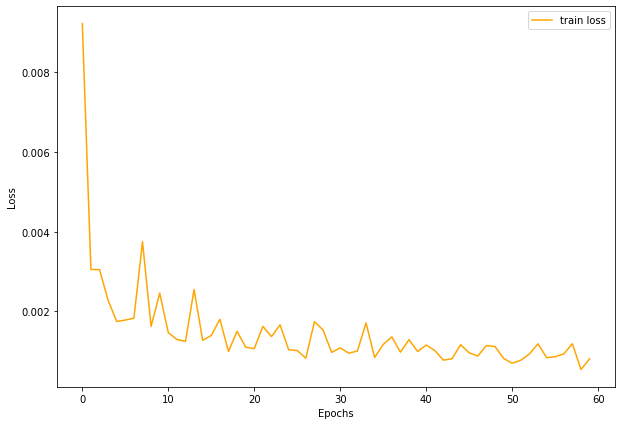

In [26]:
# Plot of Train loss
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(out_dir + 'trainloss.png')
plt.show()

# Interface

  0%|          | 0/1 [00:00<?, ?it/s]

['C:/Users/hp/anaconda3/Sem 4/S4 Project/Image Restoration/Dataset/gaussian_blurred/6_HUAWEI-MATE20_G.jpg']
Epoch 1 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 2 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 3 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 4 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 5 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 6 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 7 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 8 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 9 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 10 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 11 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 12 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 13 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 14 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 15 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 16 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 17 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 18 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 19 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 20 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 21 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 22 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 23 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 24 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 25 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 26 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 27 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 28 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 29 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 30 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 31 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 32 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 33 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 34 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 35 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 36 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 37 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 38 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 39 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 40 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 41 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 42 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 43 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 44 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 45 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 46 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 47 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 48 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 49 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 50 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 51 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 52 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 53 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 54 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 55 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 56 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 57 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 58 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 59 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.09858
Epoch 60 of 60


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Val Loss: 0.09858
Took -0.719 minutes to train


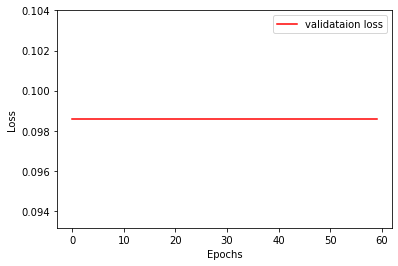

Saving model...


  0%|          | 0/1 [00:00<?, ?it/s]

['C:/Users/hp/anaconda3/Sem 4/S4 Project/Image Restoration/Dataset/gaussian_blurred/turnpike-blur.jpg']
Epoch 1 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 2 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 3 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 4 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 5 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 6 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 7 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 8 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 9 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 10 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 11 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 12 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 13 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 14 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 15 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 16 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 17 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 18 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 19 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 20 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 21 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 22 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 23 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 24 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 25 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 26 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 27 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 28 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 29 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 30 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 31 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 32 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 33 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 34 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 35 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 36 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 37 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 38 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 39 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 40 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 41 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 42 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 43 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 44 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 45 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 46 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 47 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 48 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 49 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 50 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 51 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 52 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 53 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 54 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 55 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 56 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 57 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 58 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 59 of 60


  0%|          | 0/1 [00:00<?, ?it/s]

Val Loss: 0.12850
Epoch 60 of 60


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Val Loss: 0.12850
Took -0.692 minutes to train


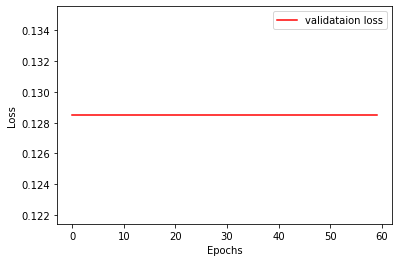

Saving model...


In [35]:
class Mainwindow(Tk):
    def __init__(self):
        super().__init__()
        w=1000
        h=800
        x=(self.winfo_screenwidth()/2)-(1000/2)
        y=0
        self.geometry("%dx%d+%d+%d" % (w,h,x,y))
        self.title("Image Restoration")
        self.configure(background="grey30")
        self.label1=Label(self,text="IMAGE RESTORATION",width=45,height=2,font=("cambria",30,"bold"),bg="grey30",fg="White")
        self.label1.place(x=5,y=10)
        self.f1=Frame(self,width=950,height=660,background="grey50")
        self.f1.place(x=25,y=110)
        self.f2=Frame(self.f1,width=450,height=490,background="grey70")
        self.f2.place(x=17,y=20)
        self.f3=Frame(self.f1,width=450,height=490,background="grey70")
        self.f3.place(x=483,y=20)
        self.f4=Frame(self.f1,width=910,height=100,background="grey70")
        self.f4.place(x=20,y=530)
        
        self.f5=LabelFrame(self.f2,width=395,height=370)
        self.f5.place(x=25,y=20)
        self.f5.img1= Label(self.f2,width=395,height=370,bg="grey70")
        self.f5.img1.place(x=25,y=20)
        self.uppath=Label(self.f2,justify=RIGHT,text="Path",width=38,height=1,font=("cambria",9,"italic"),fg="black",padx=10,pady=7)
        self.uppath.place(x=25,y=425)
        self.b1=Button(self.f2,text="Browse Image",justify="center",bg="Grey60",font=("cambria",12,"bold"),fg="Black",relief=GROOVE,width=13,command=self.uploadimg)
        self.b1.place(x=295,y=425);
        
        self.f6=LabelFrame(self.f3,width=395,height=370)
        self.f6.place(x=25,y=20)
        #self.f6.img2= Label(self.f3,width=395,height=370,bg="Royalblue3")
        #self.f6.img2.place(x=25,y=20)
        self.img2 = Canvas(self.f6,width=395,height=370,bg="grey70")
        self.img2.pack(expand=YES, fill=BOTH)
        self.b2=Button(self.f3,text="Save Image",justify="center",bg="Grey60",font=("cambria",12,"bold"),fg="Black",relief=GROOVE,width=13,command=self.saveimg)
        self.b2.place(x=155,y=425);
        
        self.b3=Button(self.f4,text="Clear",justify="center",bg="Grey60",font=("cambria",12,"bold"),fg="Black",relief=GROOVE,width=13,command=self.clr)
        self.b3.place(x=146,y=30);
        self.b4=Button(self.f4,text="Restore Image",justify="center",bg="Grey60",font=("cambria",12,"bold"),fg="Black",relief=GROOVE,width=13,command=self.restore)
        self.b4.place(x=386,y=30);
        self.b5=Button(self.f4,text="Exit",justify="center",bg="Grey60",font=("cambria",12,"bold"),fg="Black",relief=GROOVE,width=13,command=self.close)
        self.b5.place(x=613,y=30);
    def clrmsg(self):
        MsgBox = messagebox.askquestion('Clear', 'Are you sure you want to clear', icon = 'warning')  
        if MsgBox == 'yes': 
            self.clr()
    def clr(self):
            self.uppath.configure(text="Path")
            self.img2.delete('all')
            self.f2=Frame(self.f1,width=450,height=490,background="grey70")
            self.f2.place(x=17,y=20)
            self.f5=LabelFrame(self.f2,width=395,height=370)
            self.f5.place(x=25,y=20)
            self.f5.img1= Label(self.f2,width=395,height=370,bg="grey70")
            self.f5.img1.place(x=25,y=20)
            self.uppath=Label(self.f2,text="Path",width=38,height=1,font=("cambria",9,"italic"),fg="black",padx=10,pady=7)
            self.uppath.place(x=25,y=425)
            self.b1=Button(self.f2,text="Browse Image",justify="center",bg="light Grey",font=("cambria",12,"bold"),fg="Black",relief=GROOVE,width=13,command=self.uploadimg)
            self.b1.place(x=295,y=425);
    def saveimg(self):
        home = os.path.expanduser('../RestoredImages')
        svpath = filedialog.asksaveasfilename(initialdir = home,title = "Select file",filetypes = (('JPEG', ('*.jpg')),('PNG', '*.png')),defaultextension = ('JPEG', ('*.jpg')))
        if not svpath: 
            return
        if svpath is None:
            messagebox.showinfo("Information", "Unsuccessful ")
            return
        else:
            messagebox.showinfo("Information", "Saved Successfully")
            self.res.save(svpath)
    def close(self):
        MsgBox = messagebox.askquestion('Exit Application', 'Are you sure you want to exit the application', icon = 'warning')  
        if MsgBox == 'yes': 
            self.destroy()
    def restore(self):   
        a=[self.fln]
        print(a)
        # testing
        x_val = a
        val_data = DeblurDataset(x_val, y_val, transform)
        valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
        valid_loss = []
        start = time.time()
        for epoch in range(epochs):
            print(f"Epoch {epoch+1} of {epochs}")
            dataloader= valloader
            # validation
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
                    blur_image = data[0]
                    sharp_image = data[1]
                    blur_image = blur_image.to(device)
                    sharp_image = sharp_image.to(device)
                    outputs = model(blur_image)
                    loss = criterion(outputs, sharp_image)
                    running_loss += loss.item()
                    if epoch == 0 and i == (len(val_data)/dataloader.batch_size)-1:
                        save_decoded_image(blur_image.cpu().data, name=f"{image_dir}blur{epoch}.jpg")
                val_loss = running_loss/len(dataloader.dataset)
                print(f"Val Loss: {val_loss:.5f}")
                save_decoded_image(outputs.cpu().data, name=f"{image_dir}val_deblurred{epoch}.jpg")
            # End of validation
            valid_loss.append(val_loss)
            scheduler.step(val_loss)
        end = time.time()
        print(f"Took {((start-end)/60):.3f} minutes to train")
        # loss plots
        plt.plot(valid_loss, color='red', label='validataion loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(out_dir + 'validationloss.png')
        plt.show()
        # save the model to disk
        print('Saving model...')
        torch.save(model.state_dict(), out_dir + 'model.pth')
        self.res = cv2.imread(f"../outputs/saved_images/val_deblurred{epochs-1}.jpg",cv2.IMREAD_UNCHANGED)
        #self.res = cv2.cvtColor(self.res, cv2.COLOR_BGR2RGB)
        #self.res=Image.fromarray(self.res)
        self.res=cv2.resize(self.res,(395,370))
        self.res=Image.fromarray(self.res)
        self.resimg=ImageTk.PhotoImage(self.res)
        self.img2.create_image(0,0,image=self.resimg, anchor=NW)
    def uploadimg(self):
        self.clr()
        home = os.path.expanduser('..Dataset')
        self.fln = filedialog.askopenfilename(initialdir = home, title="Select An Image File",filetype=(("jpg",'*.jpg'),("png","*.png")))
        if not self.fln: 
            return
        self.basename = os.path.basename(self.fln)
        self.uppath.config(text=self.fln)
        self.img=Image.open(self.fln)
        self.img=self.img.resize((395,370))
        self.up=ImageTk.PhotoImage(self.img)
        self.f5.img1.configure(image=self.up)
        self.f5.img1.image=self.up
if __name__ == "__main__": 
    root = Mainwindow()  
    root.mainloop()